In [1]:
import pandas as pd
import glob
import xarray as xr
import numpy as np
from statsmodels.stats.anova import AnovaRM 
from scipy import stats
from matplotlib import pyplot as plt
import pingouin as pg
import numpy as np
import seaborn as sns
import scipy

In [2]:
vn = ['fusiform-rh', 'fusiform-lh', 'lingual-lh', 'lingual-rh',
'cuneus-rh','cuneus-lh', 'lateraloccipital-rh', 'lateraloccipital-lh']

methods = ['coh','ciplv','imcoh','wpli2']
#methods = ['gpdc', 'ddtf', 'psgp']  #effective measures

In [3]:
#FUNCTIONS

def outlier_indices(data):
    q1 = np.percentile(data, 25, method='midpoint')
    q3 = np.percentile(data, 75, method='midpoint')
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    upper_outliers = np.where(data >= upper)[0]
    lower_outliers = np.where(data <= lower)[0]
    outlier_index_list = list(upper_outliers) + list(lower_outliers)
    
    return outlier_index_list

def remove_outliers(data):
    outliers_removed = []
    
    for i in range(0,len(data)):
        if i not in outlier_indices(data):
            outliers_removed.append(data[i])
            
    return outliers_removed

def confint_95_diff(group1, group2):
    
    ####################################################
    #sample from pooled 1000 times
    n1 = len(group1)
    n2 = len(group2)
    
    bootstrap_sample1 = []
    bootstrap_sample2 = []
    
    for i in range(1000):
        sample1 = []
        sample2 = []
        index1 = np.random.choice(range(0,n1),n1,replace=True)
        index2 = np.random.choice(range(0,n2),n2,replace=True)
        sample1 = np.array(group1)[index1]
        sample2 = np.array(group2)[index2]
        bootstrap_sample1.append(sample1)
        bootstrap_sample2.append(sample2)
        
    diff_list = []
    for i in range(1000):
        mean1 = np.mean(bootstrap_sample1[i])
        mean2 = np.mean(bootstrap_sample2[i])
    
        diff = mean2 - mean1
        diff_list.append(diff)
    

    diff_list.sort()


    perc_025 = diff_list[24]
    perc_975 = diff_list[974]

    
    return perc_025, perc_975

In [4]:
#ASSEMBLING VARIANCE DICTIONARIES

inter_variance_dict = {}
intra_variance_dict = {}

for method in methods: 
    subject_files = glob.glob(f'/scratch/nc_outputs/{method}/*_EC.nc')

    #intra
    
    mean_per_subject = []
    for file in subject_files:
        xarray = xr.open_dataarray(file)
        var_list = []
        for sample in range(0,100):
            std = xarray.sel(bootstrap_samples=sample, region1=vn, region2=vn).values.std()
            var = std ** 2
            var_list.append(var)
        mean_per_subject.append(np.mean(var_list))
    intra_variance_dict[method] = mean_per_subject
    
    #inter
    
    all_bootstraps = []  #list of 11200 arrays
    for file in subject_files:
        xarray = xr.open_dataarray(file)
        for sample in range(0,100):
            bootstrap = xarray.sel(bootstrap_samples=sample, region1=vn, region2=vn).values
            all_bootstraps.append(bootstrap)
    
    random_bootstraps = []
    for i in range(0,112):
        index = np.random.choice(range(0,11200),100,replace=False)
        sample = np.array(all_bootstraps)[index,:]
        random_bootstraps.append(sample)

    mean_per_bootstrap = []
    for sample in random_bootstraps:
        var_list = []
        for i in range(0,100):
            std = sample[i].std()
            var = std ** 2
            var_list.append(var)
    
        mean_per_bootstrap.append(np.mean(var_list))
    
    inter_variance_dict[method] = mean_per_bootstrap

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

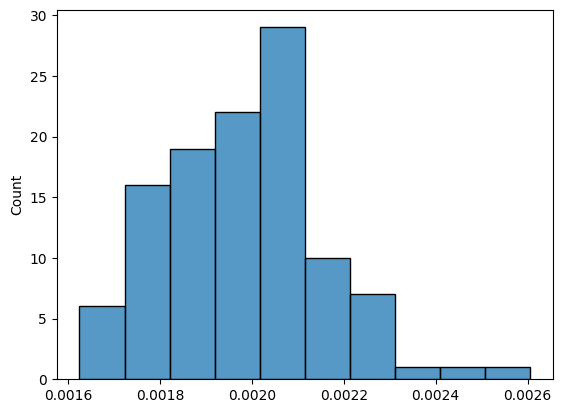

In [5]:
sns.histplot(inter_variance_dict['ciplv'])

In [6]:
#REMOVE OUTLIERS

for method in methods:
    inter_variance_dict[method] = remove_outliers(inter_variance_dict[method])
    intra_variance_dict[method] = remove_outliers(intra_variance_dict[method])

In [7]:
##CHECK SAMPLE SIZES OF DICTIONARIES

for method in methods:
    print(method, len(inter_variance_dict[method]))

for method in methods:
    print(method, len(intra_variance_dict[method]))

coh 112
ciplv 110
imcoh 108
wpli2 108


In [9]:
#CALCULATING RATIOS

ratio_dict = {}
for method in methods:
    ratio_list = []
    for inter_variance,intra_variance in zip(inter_variance_dict[method],intra_variance_dict[method]):
        ratio = inter_variance / intra_variance
        ratio_list.append(ratio)
    ratio_dict[method] = ratio_list

In [11]:
#95% CONFIDENCE INTERVALS USING BOOTSTRAP RE-SAMPLING

In [10]:
comparison_pairs = [('coh','ciplv'), ('coh','imcoh'), ('coh','wpli2'), ('ciplv','imcoh'),('ciplv','wpli2'),('imcoh','wpli2')]
#comparison_pairs = [('gpdc','psgp'), ('gpdc','ddtf'), ('ddtf','psgp')] #effective measures

In [11]:
ci_dict = {}

for pair in comparison_pairs:
    method1 = pair[0]
    method2 = pair[1]

    ci_dict[pair] = confint_95_diff(ratio_dict[method1], ratio_dict[method2])

In [ ]:
#GRAPHING

In [14]:
ratio_df = pd.DataFrame([ratio_dict['coh'], ratio_dict['ciplv'], ratio_dict['imcoh'], ratio_dict['wpli2']]).transpose()

In [15]:
headers =  ['Coh', 'ciPLV', 'imCoh', 'dwPLI']
ratio_df.columns = headers

In [16]:
ratio_df_long = ratio_df.melt(var_name='Measures', value_name='Ratios')

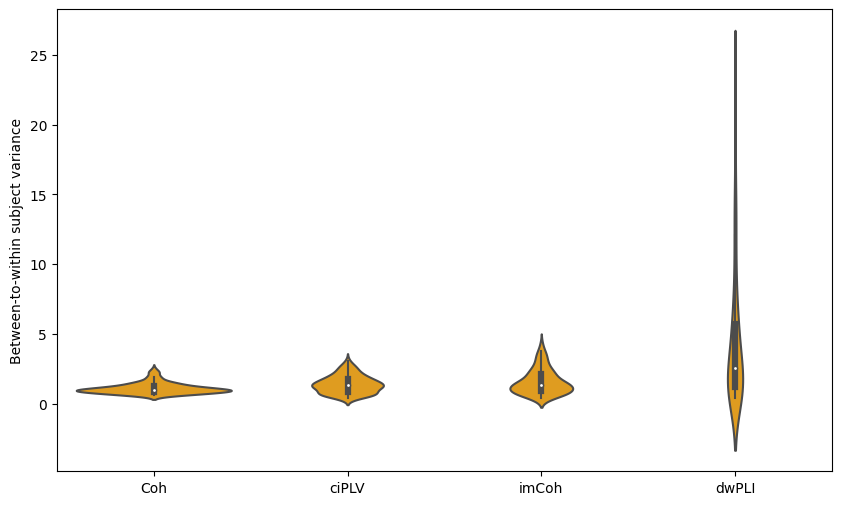

In [17]:
fig,axes = plt.subplots(1,1,figsize=(10,6))
sns.violinplot(ratio_df, color="orange")
axes.set(ylabel="Between-to-within subject variance")
plt.savefig("/scratch/figures/variance_func_fig.png",dpi=300)